In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn import metrics

from src import scale_proportional
from src import getOriginFromCropped
from src import binary, otsu, watershed, region_growing
import src.description as description

In [2]:
# !wget -O dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0" -nc
# !mkdir dataset
# !unzip -q dataset.zip -d dataset

In [3]:
# from src.data_handling import crop_dataset

# df = pd.read_csv('classifications.csv')
# crop_dataset(df)

In [4]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [5]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [6]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size / 2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

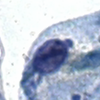

In [7]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
img = Image.fromarray(cropped_img)
img

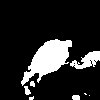

In [8]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

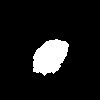

In [9]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

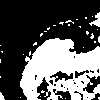

In [10]:
Image.fromarray(otsu(cropped_img, invert=True))

In [11]:
df = pd.read_csv('./main_data.csv')
df = df.drop(df.columns[[0]], axis=1)
df

,image,area,compactness,eccentricity,perimeter,label
0,./cropped_dataset/ASC-H/10.jpg,483,2.066071,0.511844,111.982755,ASC-H
1,./cropped_dataset/ASC-H/10000.jpg,673,2.907563,0.794802,156.811182,ASC-H
2,./cropped_dataset/ASC-H/10001.jpg,970,1.757551,0.497155,146.367531,ASC-H
3,./cropped_dataset/ASC-H/10002.jpg,731,1.570865,0.394551,120.124891,ASC-H
4,./cropped_dataset/ASC-H/10003.jpg,1063,1.394180,0.270889,136.468036,ASC-H
...,...,...,...,...,...,...
11529,./cropped_dataset/Negative for intraepithelial...,470,1.127330,0.478484,81.597979,Negative for intraepithelial lesion
11530,./cropped_dataset/Negative for intraepithelial...,327,1.050396,0.413155,65.698484,Negative for intraepithelial lesion
11531,./cropped_dataset/Negative for intraepithelial...,261,1.027138,0.314594,58.041630,Negative for intraepithelial lesion
11532,./cropped_dataset/Negative for intraepithelial...,835,1.574316,0.643762,128.526911,Negative for intraepithelial lesion


## Scatterplot (6)


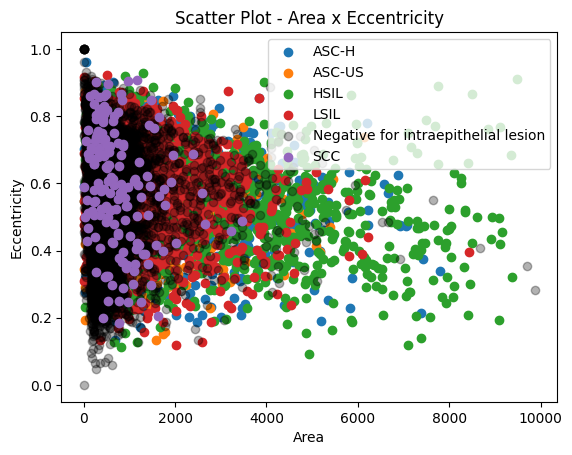

In [12]:
for label in np.unique(df['label']):
    if label == "Negative for intraepithelial lesion":
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=0.3,
            color='#000000',
        )
    else:
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=1,
        )

plt.title('Scatter Plot - Area x Eccentricity')
plt.xlabel('Area')
plt.ylabel('Eccentricity')
plt.legend(np.unique(df['label']))
plt.savefig('./model_data/scatter_all.png')
plt.show()

## Separacao dados (7)


In [13]:
X = df.drop(['label', 'image'], axis=1)  # Features
X['im_id'] = df['image'].apply(lambda p: p.split('/')[-1].split('.')[0])
y = df['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
np.unique(y_train, return_counts=True)[1] / np.unique(y_test, return_counts=True)[1]

array([4.        , 4.00826446, 3.9941349 , 4.        , 3.99926254,
       4.03125   ])

## Mahalanobis (8)


In [15]:
maha_X_train = X_train.drop(columns=['im_id'])
maha_X_test = X_test.drop(columns=['im_id'])

#### Negative x other


In [16]:
np.unique(y_train)

array(['ASC-H', 'ASC-US', 'HSIL', 'LSIL',
       'Negative for intraepithelial lesion', 'SCC'], dtype=object)

In [17]:
target_class = 'Negative for intraepithelial lesion'
mean_class_0 = maha_X_train[y_train == target_class].mean()
mean_class_1 = maha_X_train[y_train != target_class].mean()

covariance_class_0 = np.cov(maha_X_train[y_train == target_class], rowvar=False)
covariance_class_1 = np.cov(maha_X_train[y_train != target_class], rowvar=False)

inv_cov_class_0 = inv(covariance_class_0)
inv_cov_class_1 = inv(covariance_class_1)

In [18]:
test = [x.to_dict() for x in [mean_class_0, mean_class_1]]
with open("./model_data/mahalanobis/binary/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/binary/labels.json", "w") as f:
    json.dump(["Negative", 'Positive'], f)

test = [(x.tolist()) for x in [inv_cov_class_0, inv_cov_class_1]]
with open("./model_data/mahalanobis/binary/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [19]:
with open("./model_data/mahalanobis/binary/class_means.json", "r") as f:
    class_means_bin = json.load(f)
    class_means_bin = [pd.Series(series_dict) for series_dict in class_means_bin]

with open("./model_data/mahalanobis/binary/labels.json", "r") as f:
    unique_classes_bin = json.load(f)

with open("./model_data/mahalanobis/binary/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices_bin = json.load(f)

In [20]:
mahalanobis_dist_target = np.apply_along_axis(
    lambda x: mahalanobis(x, class_means_bin[0], inv_cov_matrices_bin[0]),
    axis=1,
    arr=maha_X_test,
)

mahalanobis_dist_other = np.apply_along_axis(
    lambda x: mahalanobis(x, class_means_bin[1], inv_cov_matrices_bin[1]),
    axis=1,
    arr=maha_X_test,
)

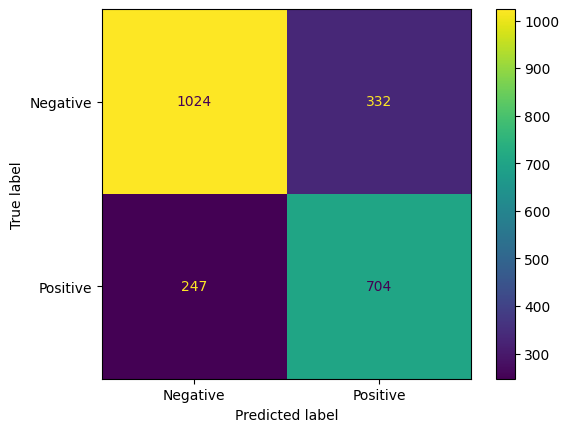

In [21]:
y_pred = np.where(mahalanobis_dist_target < mahalanobis_dist_other, 0, 1)
y_bin_test = np.where(y_test == target_class, 0, 1)

confusion_matrix = metrics.confusion_matrix(y_bin_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=unique_classes_bin
)
cm_display.plot()
plt.show()

In [22]:
print(metrics.classification_report(y_bin_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1356
           1       0.68      0.74      0.71       951

    accuracy                           0.75      2307
   macro avg       0.74      0.75      0.74      2307
weighted avg       0.75      0.75      0.75      2307



#### All classes


In [23]:
class_means = []
class_covariances = []
inv_cov_matrices = []

In [24]:
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    class_data = maha_X_train[y_train == class_label]
    class_means.append(np.mean(class_data, axis=0))
    class_covariances.append(np.cov(class_data, rowvar=False))
    inv_cov_matrices.append(inv(class_covariances[-1]))

In [25]:
mahalanobis_dists = np.zeros((len(maha_X_test), len(unique_classes)))

In [26]:
unique_classes.tolist()

['ASC-H',
 'ASC-US',
 'HSIL',
 'LSIL',
 'Negative for intraepithelial lesion',
 'SCC']

In [27]:
test = [x.to_dict() for x in class_means]
with open("./model_data/mahalanobis/multiclass/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/multiclass/labels.json", "w") as f:
    json.dump(unique_classes.tolist(), f)

test = [(x.tolist()) for x in inv_cov_matrices]
with open("./model_data/mahalanobis/multiclass/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [28]:
with open("./model_data/mahalanobis/multiclass/class_means.json", "r") as f:
    class_means = json.load(f)
    class_means = [pd.Series(series_dict) for series_dict in class_means]

with open("./model_data/mahalanobis/multiclass/labels.json", "r") as f:
    unique_classes = json.load(f)

with open("./model_data/mahalanobis/multiclass/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices = json.load(f)

In [29]:
for i, class_label in enumerate(unique_classes):
    mahalanobis_dists[:, i] = np.apply_along_axis(
        lambda x: mahalanobis(x, class_means[i], inv_cov_matrices[i]),
        axis=1,
        arr=maha_X_test,
    )

In [30]:
y_pred = np.argmin(mahalanobis_dists, axis=1)
y_pred = list(map(lambda x: unique_classes[x], y_pred))

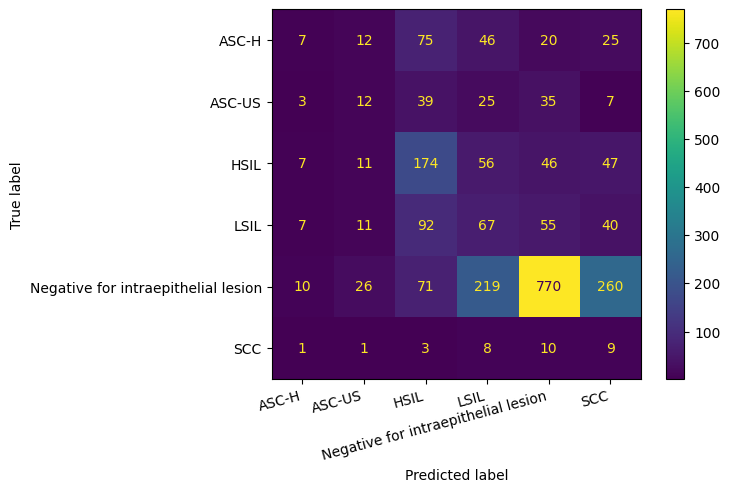

In [31]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=unique_classes
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')
plt.show()

In [32]:
print(metrics.classification_report(y_test, y_pred))

                                     precision    recall  f1-score   support

                              ASC-H       0.20      0.04      0.06       185
                             ASC-US       0.16      0.10      0.12       121
                               HSIL       0.38      0.51      0.44       341
                               LSIL       0.16      0.25      0.19       272
Negative for intraepithelial lesion       0.82      0.57      0.67      1356
                                SCC       0.02      0.28      0.04        32

                           accuracy                           0.45      2307
                          macro avg       0.29      0.29      0.26      2307
                       weighted avg       0.58      0.45      0.49      2307



In [33]:
data = (
    description.calculate_area(watershed_img),
    description.calculate_compactness(watershed_img),
    description.calculate_eccentricity(watershed_img),
    description.calculate_perimeter(watershed_img),
)

In [34]:
data

(926, 1.3365537276220156, 0.5641397645686083, 124.71067678928375)

In [35]:
test = np.zeros((1, len(unique_classes))).astype(object)
for i, class_label in enumerate(unique_classes):
    test[:, i] = {class_label: mahalanobis(data, class_means[i], inv_cov_matrices[i])}

In [36]:
for i, key in enumerate(test[0]):
    print(i, key)

0 {'ASC-H': 1.0095576945182008}
1 {'ASC-US': 0.9775457824304498}
2 {'HSIL': 1.0981514278125184}
3 {'LSIL': 0.9135418744389565}
4 {'Negative for intraepithelial lesion': 1.0333296220657857}
5 {'SCC': 1.1995378445642173}


## Rede Neural (9)


In [37]:
import numpy as np
import tensorflow as tf
import glob
from sklearn.preprocessing import LabelEncoder

In [130]:
from keras import Input
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Rescaling,
    BatchNormalization,
    Resizing
)
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications import MobileNetV2

In [39]:
def plot_results(history, show=True):
    hist_df = None
    if hasattr(history, 'history'):
        hist_df = pd.DataFrame(history.history)
    else:
        hist_df = pd.DataFrame(history)
    # hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    if show:
        plt.show()
    else:
        return fig, axs

In [40]:
def get_padding(image, pad_to):
    w, h = image.size
    h_padding = (pad_to - w) / 2
    v_padding = (pad_to - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding + 0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding + 0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding - 0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding - 0.5
    padding = [[int(t_pad), int(b_pad)], [int(l_pad), int(r_pad)], [0, 0]]
    return padding


def pad(img, pad_to=100):
    return tf.pad(
        tf.keras.utils.img_to_array(img, dtype=int),
        get_padding(img, pad_to),
        "CONSTANT",
        0,
    )

### Preparando Datasets

In [41]:
def get_images(root_dir='./cropped_dataset/*', include_ids=None):
    images = []
    labels = []

    for p in glob.glob(os.path.join(root_dir, '*.jpg')):
        label = p.split('\\')[-2]
        if label == 'Negative for intraepithelial lesion':
            label = 'Negative'
        id = p.split('\\')[-1].split('.')[0]
        path = p

        if include_ids is not None:
            if int(id) not in include_ids:
                continue

        im = Image.open(path)
        im = pad(im)
        images.append(im)
        labels.append(label)

    return (np.asarray(images), np.asarray(labels))

In [42]:
# gerando dados de validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
X_train.shape, X_val.shape

((8304, 5), (923, 5))

In [43]:
X_train_nn, y_train_nn = get_images(include_ids=X_train['im_id'])
X_val_nn, y_val_nn = get_images(include_ids=X_val['im_id'])
X_test_nn, y_test_nn = get_images(include_ids=X_test['im_id'])

In [44]:
label_encoder = LabelEncoder()
y_train_all_classes = label_encoder.fit_transform(y_train_nn)
y_val_all_classes = label_encoder.transform(y_val_nn)
y_test_all_classes = label_encoder.transform(y_test_nn)

y_train_nn_ispos = np.where(y_train_nn != 'Negative', 1, 0)
y_val_nn_ispos = np.where(y_val_nn != 'Negative', 1, 0)
y_test_nn_ispos = np.where(y_test_nn != 'Negative', 1, 0)

In [45]:
np.save('.\\model_data\\nn\\label_encoder_classes.npy', label_encoder.classes_)

In [46]:
label_encoder_bin = LabelEncoder()
label_encoder_bin.fit(['Negative', 'Positive'])
np.save('.\\model_data\\nn\\label_encoder_bin.npy', label_encoder_bin.classes_)

In [47]:
train_ds_all = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_all_classes))
val_ds_all = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_all_classes))
test_ds_all = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_all_classes))

train_ds_pos = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn_ispos))
val_ds_pos = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn_ispos))
test_ds_pos = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_nn_ispos))

In [48]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 8196

train_data_all = train_ds_all.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_all = val_ds_all.batch(BATCH_SIZE)
test_data_all = test_ds_all.batch(BATCH_SIZE)

train_data_pos = train_ds_pos.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_pos = val_ds_pos.batch(BATCH_SIZE)
test_data_pos = test_ds_pos.batch(BATCH_SIZE)

### Modelo Baseline

#### Pos x Neg

In [49]:
pos_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\binary\\model.keras'
)
pos_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_39 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 32)        184

In [ ]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

pos_model = tf.keras.Model(inputs=input, outputs=output)
pos_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_27 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 32)        1846

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

pos_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_model.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

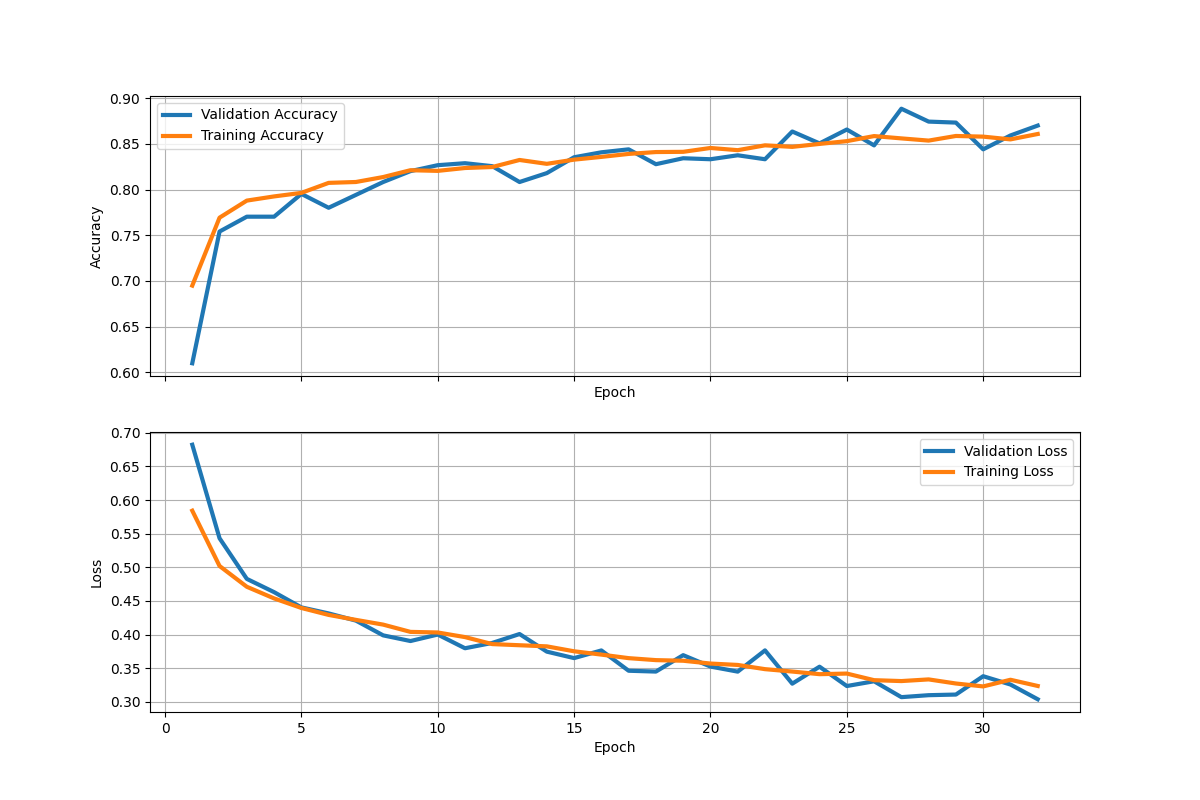

In [ ]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\posxneg\\graph.png')
plt.show()

 1/73 [..............................] - ETA: 2s

73/73 [==============================] - 2s 28ms/step


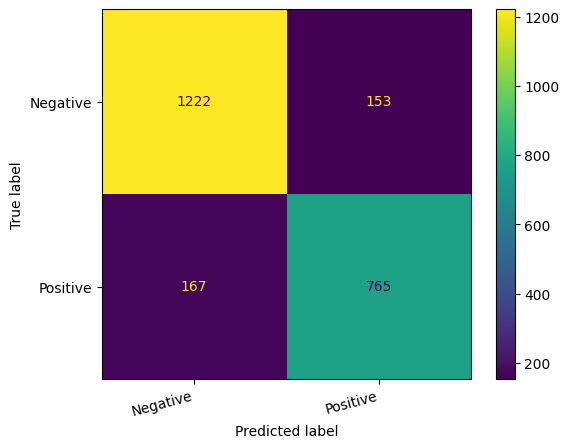

In [59]:
y_pred = np.where(pos_model.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\binary\\confusion_matrix.png')
plt.show()

In [ ]:
pos_model.evaluate(test_data_pos)

73/73 [==============================] - 3s 26ms/step - loss: 0.3251 - accuracy: 0.8613


[0.3251415193080902, 0.8612917065620422]

In [60]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1375
           1       0.83      0.82      0.83       932

    accuracy                           0.86      2307
   macro avg       0.86      0.85      0.86      2307
weighted avg       0.86      0.86      0.86      2307



In [ ]:
pos_model.save('.\\model_data\\nn\\baseline\\binary\\model.keras')

#### All Classes

In [48]:
all_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\multiclass\\model.keras'
)
all_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_48 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 47, 47, 32)        184

In [154]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(6, activation='softmax')(hidden2)

all_model = tf.keras.Model(inputs=input, outputs=output)
all_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_27 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 32)        1846

In [114]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_model.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

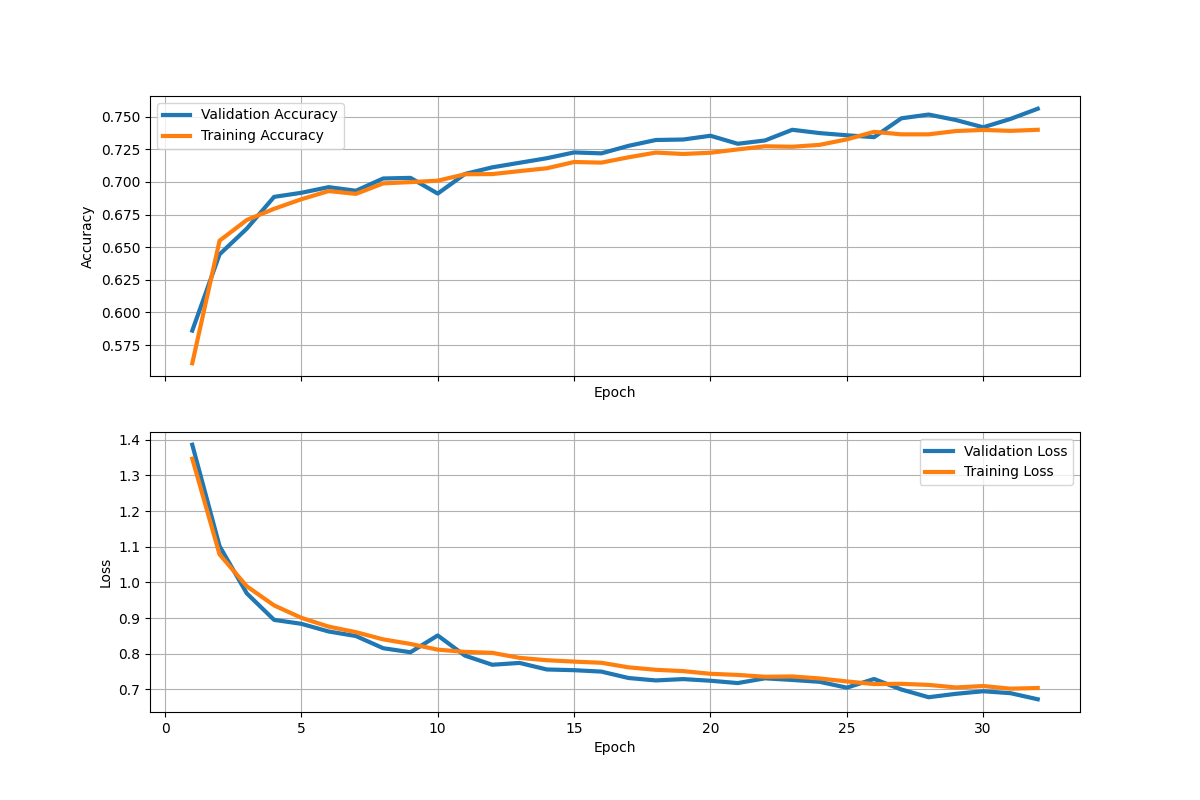

In [66]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\all_classes\\graph.png')
plt.show()

 1/73 [..............................] - ETA: 2s

73/73 [==============================] - 12s 163ms/step


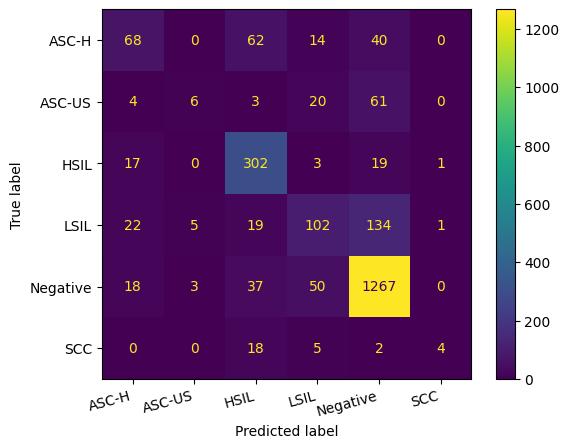

In [73]:
y_pred = np.argmax(all_model.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)


cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\multiclass\\confusion_matrix.png')
plt.show()

In [70]:
all_model.evaluate(test_data_all)

73/73 [==============================] - 3s 34ms/step - loss: 0.6769 - accuracy: 0.7581


[0.6769126057624817, 0.7581274509429932]

In [63]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.37      0.43       184
           1       0.43      0.06      0.11        94
           2       0.68      0.88      0.77       342
           3       0.53      0.36      0.43       283
           4       0.83      0.92      0.87      1375
           5       0.67      0.14      0.23        29

    accuracy                           0.76      2307
   macro avg       0.61      0.46      0.47      2307
weighted avg       0.73      0.76      0.73      2307



In [ ]:
all_model.save('.\\model_data\\nn\\baseline\\all_classes\\model.keras')

### Modelo Resnet

#### Pos x Neg

In [65]:
pos_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\binary\\model.keras'
)
pos_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [91]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
resnet = ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_resnet = tf.keras.Model(inputs=input, outputs=output)
pos_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 100, 100, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling_3[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']        

In [92]:
# number of layers that will be trained
trainable_layers = len(pos_resnet.layers)/5

for i, l in enumerate(pos_resnet.layers):
    if len(pos_model.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

pos_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_resnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

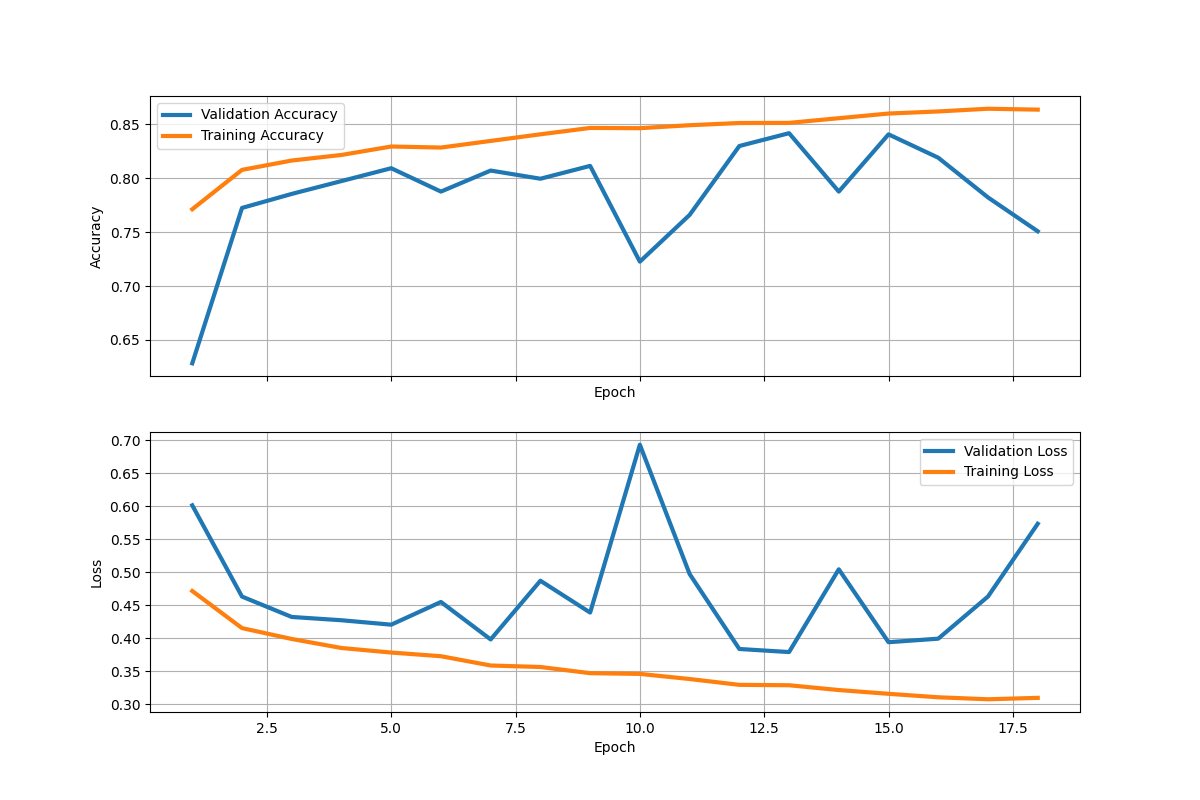

In [81]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\posxneg\\graph.png')
plt.show()

73/73 [==============================] - 16s 144ms/step


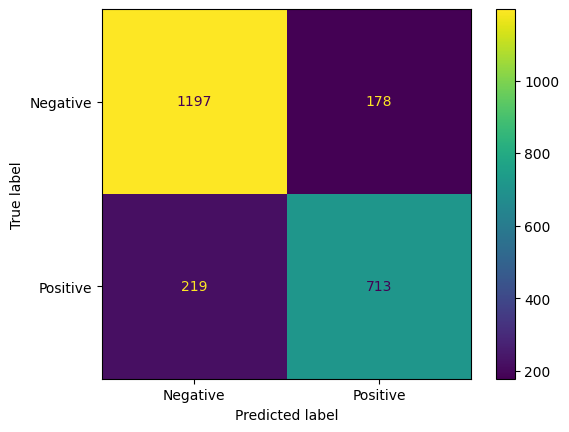

In [66]:
y_pred = np.where(pos_resnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\resnet\\binary\\confusion_matrix.png')
plt.show()

In [83]:
pos_resnet.evaluate(test_data_pos)

73/73 [==============================] - 13s 142ms/step - loss: 0.3960 - accuracy: 0.8279


[0.39599233865737915, 0.8279150128364563]

In [67]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1375
           1       0.80      0.77      0.78       932

    accuracy                           0.83      2307
   macro avg       0.82      0.82      0.82      2307
weighted avg       0.83      0.83      0.83      2307



In [ ]:
pos_resnet.save('.\\model_data\\nn\\resnet\\binary\\model.keras')

#### All Classes

In [69]:
all_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\multiclass\\model.keras'
)
all_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [96]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
resnet = ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_resnet = tf.keras.Model(inputs=input, outputs=output)
all_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 100, 100, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling_4[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']        

In [97]:
# number of layers that will be trained
trainable_layers = len(all_resnet.layers) / 6

for i, l in enumerate(all_resnet.layers):
    if len(all_resnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_resnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

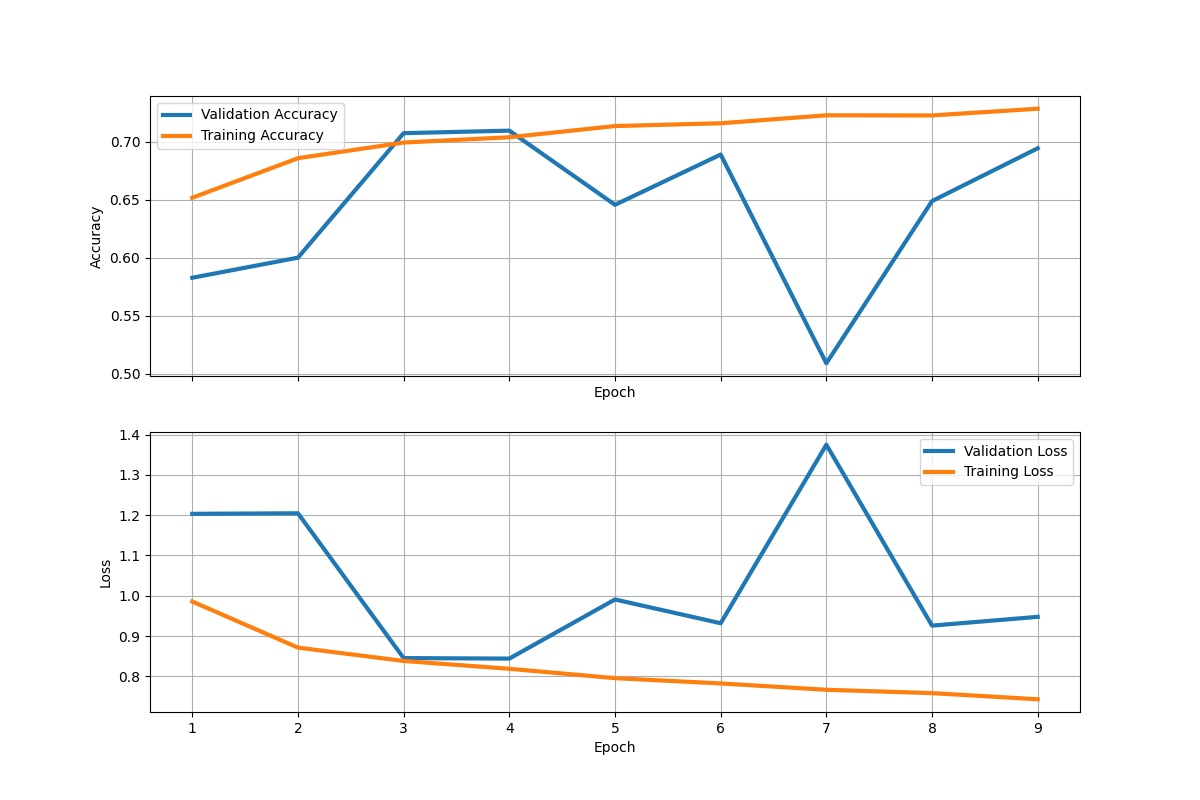

In [100]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\multiclass\\graph.png')
plt.show()

 1/73 [..............................] - ETA: 3s

73/73 [==============================] - 10s 138ms/step


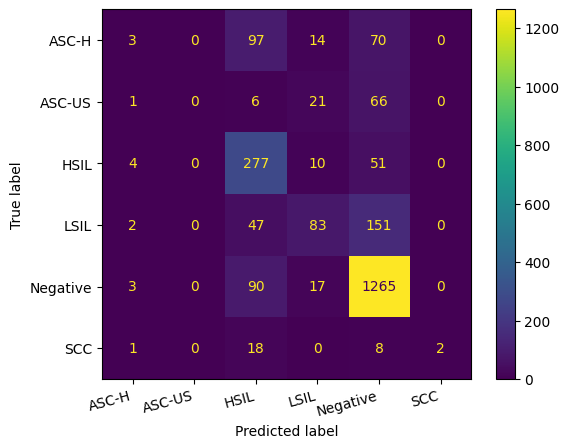

In [71]:
y_pred = np.argmax(all_resnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\resnet\\multiclass\\confusion_matrix.png')
plt.show()

In [102]:
all_resnet.evaluate(test_data_all)

73/73 [==============================] - 13s 138ms/step - loss: 0.8267 - accuracy: 0.7065


[0.8266584873199463, 0.7065452933311462]

In [72]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.02      0.03       184
           1       0.00      0.00      0.00        94
           2       0.52      0.81      0.63       342
           3       0.57      0.29      0.39       283
           4       0.79      0.92      0.85      1375
           5       1.00      0.07      0.13        29

    accuracy                           0.71      2307
   macro avg       0.51      0.35      0.34      2307
weighted avg       0.64      0.71      0.65      2307



d:\leocg\Documents\PUCProjetos\7oPeriodo\PAI\pai-flower-nucleus\pai\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\leocg\Documents\PUCProjetos\7oPeriodo\PAI\pai-flower-nucleus\pai\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\leocg\Documents\PUCProjetos\7oPeriodo\PAI\pai-flower-nucleus\pai\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [ ]:
all_resnet.save('.\\model_data\\nn\\resnet\\all_classes\\model.keras')

### Modelo EfficientNet

#### Pos x Neg

In [148]:
pos_effnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\efficientNet\\binary\\model.keras'
)
pos_effnet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 100, 100, 3)  0           ['input_8[0][0]']                
                                                                                                  
 rescaling_15 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_14[0][0]']           
                                                                                                  
 normalization_7 (Normalization  (None, 100, 100, 3)  7          ['rescaling_15[0][0]']     

In [149]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
effnet = EfficientNetB3(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(effnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_effnet = tf.keras.Model(inputs=input, outputs=output)
pos_effnet.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_36 (Rescaling)       (None, 100, 100, 3)  0           ['input_26[0][0]']               
                                                                                                  
 rescaling_37 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_36[0][0]']           
                                                                                                  
 normalization_12 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_37[0][0]']    

In [150]:
# number of layers that will be trained
trainable_layers = len(pos_effnet.layers)/5

for i, l in enumerate(pos_effnet.layers):
    if len(pos_effnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

pos_effnet.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_36 (Rescaling)       (None, 100, 100, 3)  0           ['input_26[0][0]']               
                                                                                                  
 rescaling_37 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_36[0][0]']           
                                                                                                  
 normalization_12 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_37[0][0]']    

In [151]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

pos_effnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [152]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_effnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 19s 52ms/step - loss: 0.6865 - accuracy: 0.5732 - val_loss: 0.6752 - val_accuracy: 0.5818
Epoch 2/32
260/260 [==============================] - 12s 47ms/step - loss: 0.6558 - accuracy: 0.6079 - val_loss: 0.6629 - val_accuracy: 0.6121
Epoch 3/32
260/260 [==============================] - 12s 46ms/step - loss: 0.6399 - accuracy: 0.6292 - val_loss: 0.7143 - val_accuracy: 0.5395
Epoch 4/32
260/260 [==============================] - 12s 46ms/step - loss: 0.6220 - accuracy: 0.6462 - val_loss: 0.5552 - val_accuracy: 0.6901
Epoch 5/32
260/260 [==============================] - 12s 46ms/step - loss: 0.6138 - accuracy: 0.6519 - val_loss: 0.5554 - val_accuracy: 0.6999
Epoch 6/32
260/260 [==============================] - 12s 46ms/step - loss: 0.6015 - accuracy: 0.6683 - val_loss: 0.6083 - val_accuracy: 0.6728
Epoch 7/32
260/260 [==============================] - 12s 47ms/step - loss: 0.5883 - accuracy: 0.6805 - val_loss: 0.5198 - val_accuracy: 0.7411
Epo

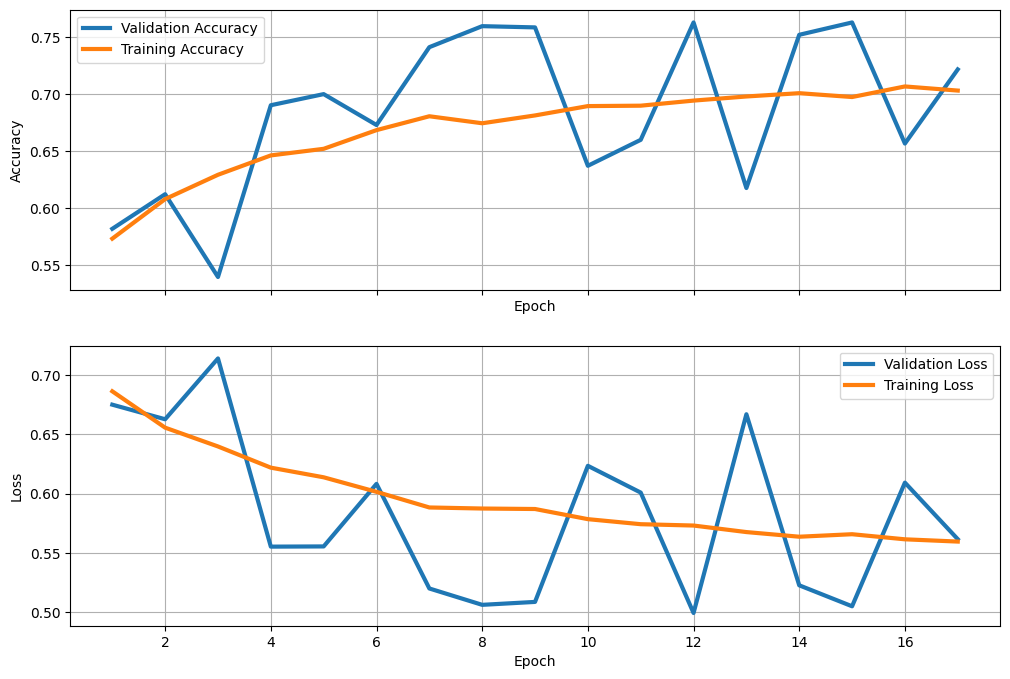

In [153]:
fig, axs = plot_results(history, show=False)
# plt.savefig('.\\model_data\\nn\\efficientNet\\binary\\graph.png')
plt.show()

73/73 [==============================] - 4s 30ms/step


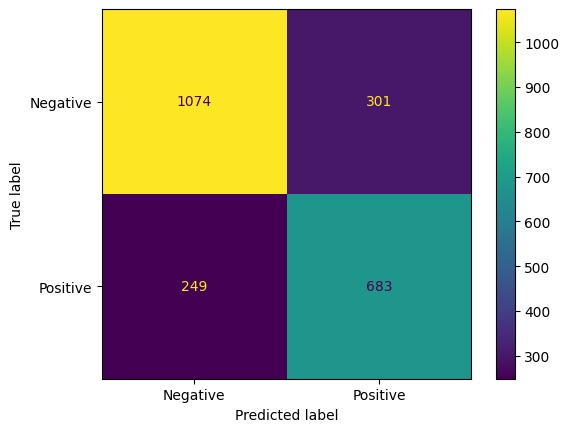

In [154]:
y_pred = np.where(pos_effnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

# plt.savefig('.\\model_data\\nn\\efficientNet\\binary\\confusion_matrix.png')
plt.show()

In [155]:
pos_effnet.evaluate(test_data_pos)

73/73 [==============================] - 2s 29ms/step - loss: 0.5066 - accuracy: 0.7616


[0.5065547227859497, 0.7615951299667358]

In [156]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1375
           1       0.69      0.73      0.71       932

    accuracy                           0.76      2307
   macro avg       0.75      0.76      0.75      2307
weighted avg       0.76      0.76      0.76      2307



In [84]:
pos_effnet.save('.\\model_data\\nn\\efficientNet\\binary\\model.keras')

#### All Classes

In [ ]:
all_effnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\efficientNet\\multiclass\\model.keras'
)
all_effnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 100, 100, 3)  0           ['input_9[0][0]']                
                                                                                                  
 rescaling_17 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_16[0][0]']           
                                                                                                  
 normalization_8 (Normalization  (None, 100, 100, 3)  7          ['rescaling_17[0][0]']     

In [140]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
effnet = EfficientNetB3(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(effnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_effnet = tf.keras.Model(inputs=input, outputs=output)
all_effnet.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_34 (Rescaling)       (None, 100, 100, 3)  0           ['input_25[0][0]']               
                                                                                                  
 rescaling_35 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_34[0][0]']           
                                                                                                  
 normalization_11 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_35[0][0]']    

In [141]:
# number of layers that will be trained
trainable_layers = len(all_effnet.layers) / 5

for i, l in enumerate(all_effnet.layers):
    if len(all_effnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

all_effnet.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_34 (Rescaling)       (None, 100, 100, 3)  0           ['input_25[0][0]']               
                                                                                                  
 rescaling_35 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_34[0][0]']           
                                                                                                  
 normalization_11 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_35[0][0]']    

In [142]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

all_effnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [143]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_effnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 19s 52ms/step - loss: 1.3268 - accuracy: 0.5645 - val_loss: 1.3191 - val_accuracy: 0.5818
Epoch 2/32
260/260 [==============================] - 12s 47ms/step - loss: 1.2539 - accuracy: 0.5857 - val_loss: 1.1549 - val_accuracy: 0.5818
Epoch 3/32
260/260 [==============================] - 12s 46ms/step - loss: 1.2306 - accuracy: 0.5882 - val_loss: 1.1550 - val_accuracy: 0.5926
Epoch 4/32
260/260 [==============================] - 12s 47ms/step - loss: 1.2127 - accuracy: 0.5930 - val_loss: 1.1412 - val_accuracy: 0.6035
Epoch 5/32
260/260 [==============================] - 12s 46ms/step - loss: 1.1984 - accuracy: 0.5932 - val_loss: 1.1945 - val_accuracy: 0.6230
Epoch 6/32
260/260 [==============================] - 12s 45ms/step - loss: 1.1911 - accuracy: 0.5968 - val_loss: 1.0932 - val_accuracy: 0.6306
Epoch 7/32
260/260 [==============================] - 12s 45ms/step - loss: 1.1645 - accuracy: 0.6036 - val_loss: 1.0457 - val_accuracy: 0.6186
Epo

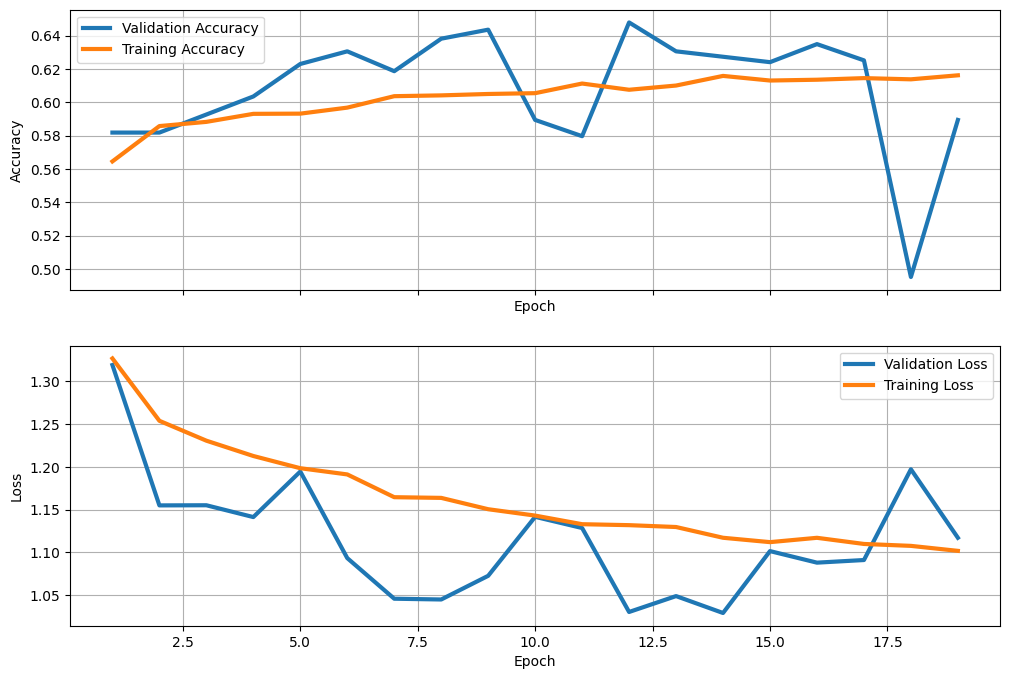

In [144]:
fig, axs = plot_results(history, show=False)
# plt.savefig('.\\model_data\\nn\\efficientNet\\multiclass\\graph.png')
plt.show()

73/73 [==============================] - 4s 34ms/step


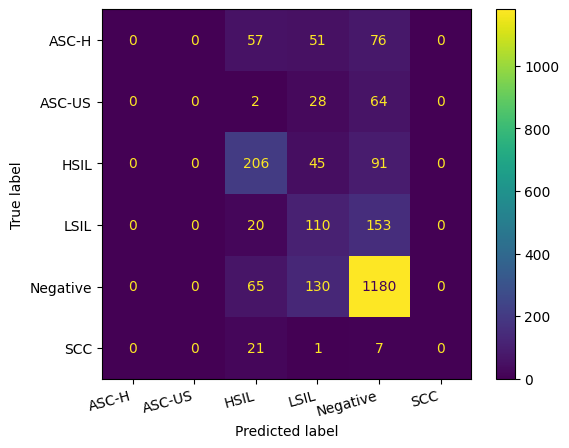

In [145]:
y_pred = np.argmax(all_effnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

# plt.savefig('.\\model_data\\nn\\efficientNet\\multiclass\\confusion_matrix.png')
plt.show()

In [146]:
all_effnet.evaluate(test_data_all)

73/73 [==============================] - 2s 28ms/step - loss: 1.0196 - accuracy: 0.6485


[1.0195832252502441, 0.6484612226486206]

In [147]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.00      0.00      0.00        94
           2       0.56      0.60      0.58       342
           3       0.30      0.39      0.34       283
           4       0.75      0.86      0.80      1375
           5       0.00      0.00      0.00        29

    accuracy                           0.65      2307
   macro avg       0.27      0.31      0.29      2307
weighted avg       0.57      0.65      0.60      2307



c:\Users\leocg\anaconda3\envs\paiTF\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leocg\anaconda3\envs\paiTF\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leocg\anaconda3\envs\paiTF\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
all_effnet.save('.\\model_data\\nn\\efficientNet\\multiclass\\model.keras')

### Modelo MobileNet

#### Pos x Neg

In [ ]:
pos_mobnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\mobileNet\\binary\\model.keras'
)
pos_mobnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [157]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
mobnet = MobileNetV2(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(mobnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_mobnet = tf.keras.Model(inputs=input, outputs=output)
pos_mobnet.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_38 (Rescaling)       (None, 100, 100, 3)  0           ['input_27[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['rescaling_38[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']           

In [158]:
# number of layers that will be trained
trainable_layers = len(pos_mobnet.layers)/5

for i, l in enumerate(pos_mobnet.layers):
    if len(pos_mobnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

pos_mobnet.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_38 (Rescaling)       (None, 100, 100, 3)  0           ['input_27[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['rescaling_38[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']           

In [159]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)

pos_mobnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [160]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_mobnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 10s 29ms/step - loss: 0.6249 - accuracy: 0.6667 - val_loss: 0.6601 - val_accuracy: 0.6858
Epoch 2/32
260/260 [==============================] - 6s 21ms/step - loss: 0.4617 - accuracy: 0.7789 - val_loss: 0.5510 - val_accuracy: 0.7595
Epoch 3/32
260/260 [==============================] - 6s 22ms/step - loss: 0.4067 - accuracy: 0.8156 - val_loss: 0.4718 - val_accuracy: 0.7811
Epoch 4/32
260/260 [==============================] - 6s 21ms/step - loss: 0.3746 - accuracy: 0.8301 - val_loss: 0.4286 - val_accuracy: 0.8158
Epoch 5/32
260/260 [==============================] - 6s 22ms/step - loss: 0.3493 - accuracy: 0.8481 - val_loss: 0.4017 - val_accuracy: 0.8191
Epoch 6/32
260/260 [==============================] - 6s 21ms/step - loss: 0.3257 - accuracy: 0.8557 - val_loss: 0.3814 - val_accuracy: 0.8299
Epoch 7/32
260/260 [==============================] - 6s 21ms/step - loss: 0.3061 - accuracy: 0.8694 - val_loss: 0.3680 - val_accuracy: 0.8364
Epoch 8/3

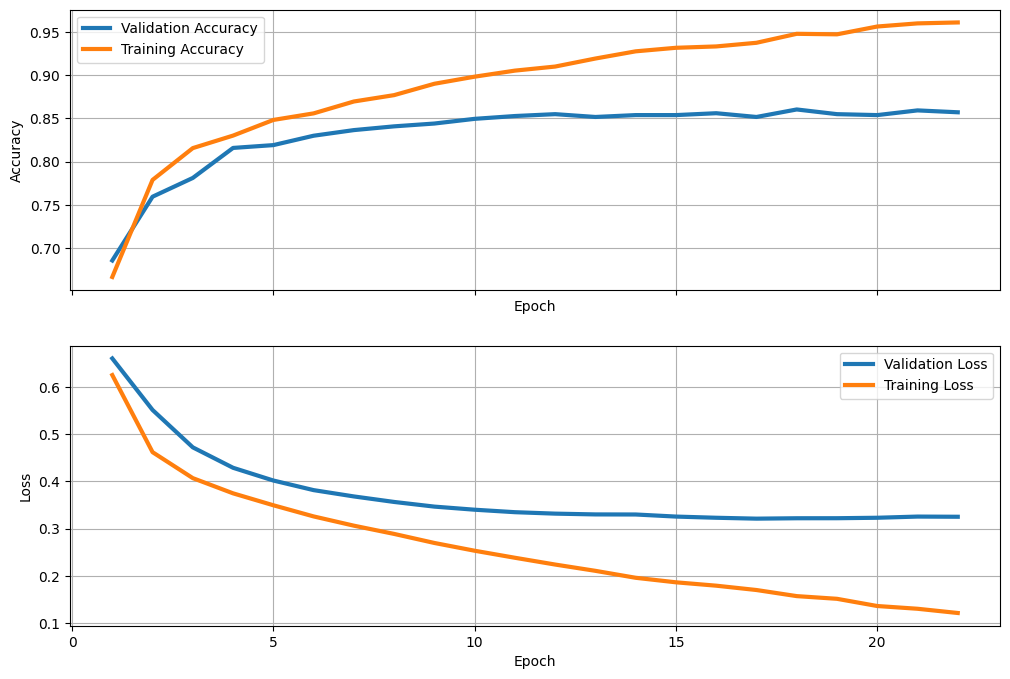

In [167]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\mobileNet\\binary\\graph.png')
plt.show()

 1/73 [..............................] - ETA: 3s

73/73 [==============================] - 1s 18ms/step


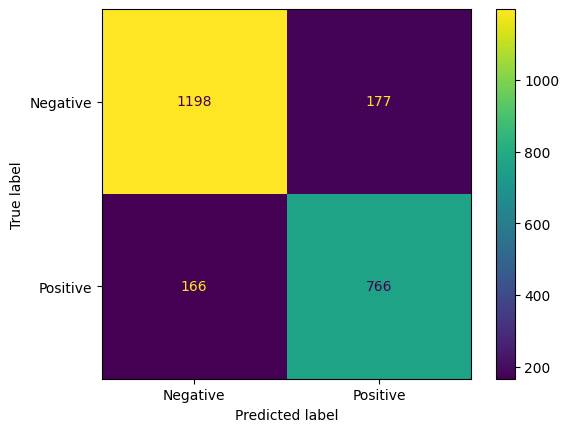

In [166]:
y_pred = np.where(pos_mobnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\mobileNet\\binary\\confusion_matrix.png')
plt.show()

In [163]:
pos_mobnet.evaluate(test_data_pos)

73/73 [==============================] - 1s 18ms/step - loss: 0.3521 - accuracy: 0.8513


[0.3520852029323578, 0.8513220548629761]

In [164]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1375
           1       0.81      0.82      0.82       932

    accuracy                           0.85      2307
   macro avg       0.85      0.85      0.85      2307
weighted avg       0.85      0.85      0.85      2307



In [165]:
pos_mobnet.save('.\\model_data\\nn\\mobileNet\\binary\\model.keras')

#### All Classes

In [ ]:
all_mobnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\mobileNet\\multiclass\\model.keras'
)
all_mobnet.summary()

In [218]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
effnet = MobileNetV2(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(effnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_mobnet = tf.keras.Model(inputs=input, outputs=output)
all_mobnet.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_47 (Rescaling)       (None, 100, 100, 3)  0           ['input_36[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['rescaling_47[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']           

In [219]:
# number of layers that will be trained
trainable_layers = len(all_mobnet.layers) / 5

for i, l in enumerate(all_mobnet.layers):
    if len(all_mobnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

all_mobnet.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_47 (Rescaling)       (None, 100, 100, 3)  0           ['input_36[0][0]']               
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['rescaling_47[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']           

 wiseConv2D)                                                                                      
                                                                                                  
 expanded_conv_depthwise_BN (Ba  (None, 50, 50, 32)  128         ['expanded_conv_depthwise[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 50, 50, 32)  0           ['expanded_conv_depthwise_BN[0][0
 ReLU)                                                           ]']                              
                                                                                                  
 expanded_conv_project (Conv2D)  (None, 50, 50, 16)  512         ['expanded_conv_depthwise_relu[0]
                                                                 [0]']                            
          

In [220]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

all_mobnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [221]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_mobnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 13s 40ms/step - loss: 1.2384 - accuracy: 0.5611 - val_loss: 2.0459 - val_accuracy: 0.2969
Epoch 2/32
260/260 [==============================] - 6s 22ms/step - loss: 0.9038 - accuracy: 0.6777 - val_loss: 1.3325 - val_accuracy: 0.5125
Epoch 3/32
260/260 [==============================] - 6s 22ms/step - loss: 0.7907 - accuracy: 0.7162 - val_loss: 1.0487 - val_accuracy: 0.6208
Epoch 4/32
260/260 [==============================] - 6s 22ms/step - loss: 0.7079 - accuracy: 0.7476 - val_loss: 0.8838 - val_accuracy: 0.6771
Epoch 5/32
260/260 [==============================] - 6s 21ms/step - loss: 0.6499 - accuracy: 0.7725 - val_loss: 0.8137 - val_accuracy: 0.7064
Epoch 6/32
260/260 [==============================] - 6s 22ms/step - loss: 0.5934 - accuracy: 0.7895 - val_loss: 0.7683 - val_accuracy: 0.7151
Epoch 7/32
260/260 [==============================] - 6s 22ms/step - loss: 0.5301 - accuracy: 0.8114 - val_loss: 0.7465 - val_accuracy: 0.7140
Epoch 8/3

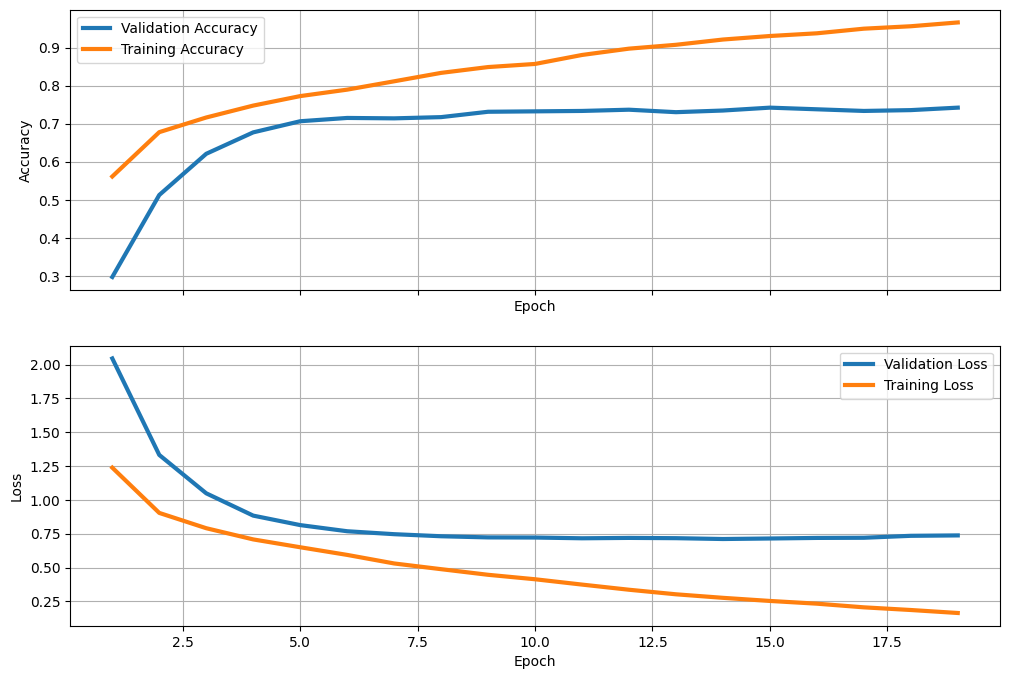

In [223]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\mobileNet\\multiclass\\graph.png')
plt.show()

73/73 [==============================] - 2s 17ms/step


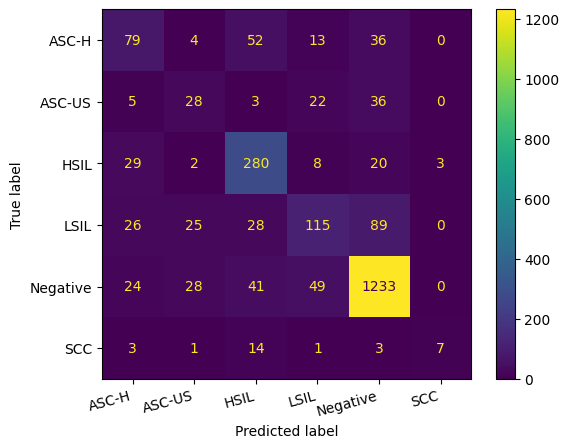

In [224]:
y_pred = np.argmax(all_mobnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\mobileNet\\multiclass\\confusion_matrix.png')
plt.show()

In [222]:
all_mobnet.evaluate(test_data_all)

73/73 [==============================] - 1s 17ms/step - loss: 0.7127 - accuracy: 0.7551


[0.7127447128295898, 0.7550932168960571]

In [225]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.43      0.45       184
           1       0.32      0.30      0.31        94
           2       0.67      0.82      0.74       342
           3       0.55      0.41      0.47       283
           4       0.87      0.90      0.88      1375
           5       0.70      0.24      0.36        29

    accuracy                           0.76      2307
   macro avg       0.60      0.52      0.53      2307
weighted avg       0.75      0.76      0.75      2307



In [226]:
all_mobnet.save('.\\model_data\\nn\\mobileNet\\multiclass\\model.keras')